In [1]:
from sentence_transformers import SentenceTransformer, util
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

In [76]:
model = SentenceTransformer('all-mpnet-base-v2', device='cuda')

In [95]:
sentences = ['John ate a potato.',
    'There are three birds flying in the sky.']
sentence_embeddings = model.encode(sentences)

In [96]:
util.pairwise_cos_sim(torch.tensor([sentence_embeddings[0]]), torch.tensor([sentence_embeddings[1]]))

tensor([-0.0482])

In [3]:
# load datasets
df_chaos_train = pd.read_csv('data/df_chaos_train.csv')
df_chaos_val = pd.read_csv('data/df_chaos_val.csv')
df_chaos_test = pd.read_csv('data/df_chaos_test.csv')

In [41]:
# adding sentence embeddings
for df in [df_chaos_train, df_chaos_val, df_chaos_test]:
    ps = df['premise'].values.tolist()
    hs = df['hypothesis'].values.tolist()
    p_embeddings = model.encode(ps, convert_to_tensor=True)
    h_embeddings = model.encode(hs, convert_to_tensor=True)
    # df['p_embedding'] = p_embeddings
    # df['h_embedding'] = h_embeddings
    cos_sim = util.pairwise_cos_sim(p_embeddings, h_embeddings)
    df['cos_sim'] = cos_sim.cpu()
    df['arc_cos'] = torch.acos(cos_sim).cpu()*180/np.pi
    

In [35]:
data_dict = {}

p_embs = model.encode(list(df_chaos_train['premise'].values), convert_to_tensor=True)
h_embs = model.encode(list(df_chaos_train['hypothesis'].values), convert_to_tensor=True)
cos_sim = util.pairwise_cos_sim(p_embs, h_embs)



for index, row in df_chaos_train.iterrows():
    uid = row['uid']
    
    temp_dict = row[['label_dist', 'majority_label', 'entropy', 'premise', 'hypothesis']].to_dict()
    temp_dict['p_embedding'] = p_embs[index]
    temp_dict['h_embedding'] = h_embs[index]
    temp_dict['cos_sim'] = cos_sim[index]
    
    data_dict[uid] = temp_dict

In [24]:
with open('data/data_embedding.pkl', 'wb') as f:
    pickle.dump(data_dict, f)
    f.close()

In [43]:
for k, v in data_dict.items():
    print(v['entropy'])
    break

0.5052482226498788


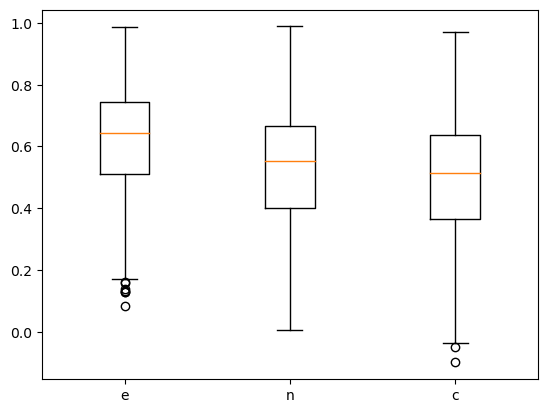

In [49]:
my_dict = {'e': [], 'n': [], 'c':[]}

for k, v in data_dict.items():
    my_dict[v['majority_label']].append(v['cos_sim'].cpu().numpy())

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
plt.show()

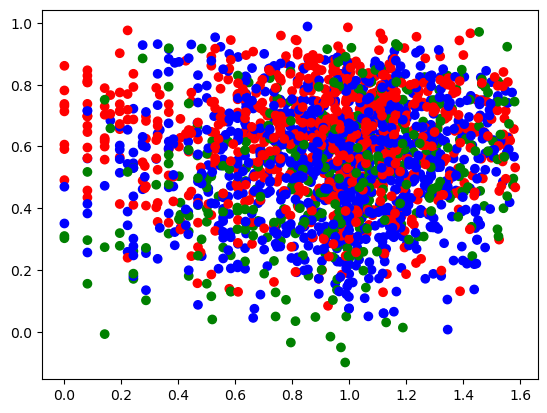

In [48]:
x_entropy = []
y_sim = []
colors = []

color_map = {'e': 'red', 'n': 'blue', 'c': 'green'}

for k, v in data_dict.items():
    x_entropy.append(v['entropy'])
    y_sim.append(v['cos_sim'].cpu().numpy())
    colors.append(color_map[v['majority_label']])


# fig, ax = plt.subplots()
# ax.boxplot(my_dict.values())
# ax.set_xticklabels(my_dict.keys())
plt.scatter(x_entropy, y_sim, c=colors)
plt.show()

In [47]:
file_names = [
    'data/embedding/sentence-transformers/all-MiniLM-L6-v2/dataset_chaos_train.pkl',
    'data/embedding/sentence-transformers/roberta-base-nli-mean-tokens/dataset_chaos_train.pkl',
    'data/embedding/sentence-transformers/all-mpnet-base-v2/dataset_chaos_train.pkl',
    'data/embedding/mini_R2_soft_soft/dataset_chaos_train.pkl',
    'data/embedding/robertaNLI_R2_soft_soft/dataset_chaos_train.pkl',
    'data/embedding/mpnet_R2_soft_soft/dataset_chaos_train.pkl',
]

In [45]:
with open('data/embedding/mini_R2_SKIP_soft/dataset_chaos_train.pkl', 'rb') as f:
    train = pickle.load(f)
    f.close

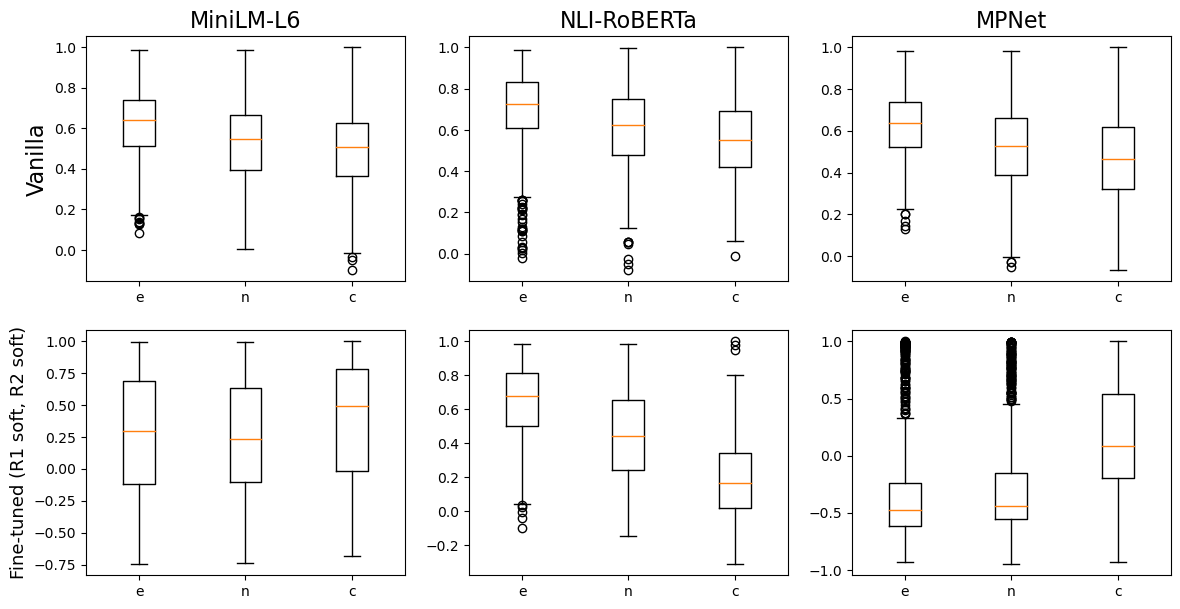

In [75]:
plt.figure(figsize=(14,7))
for num, name in enumerate(file_names):
    with open(name, 'rb') as f:
        train = pickle.load(f)
        f.close
    
    p_embs = []
    h_embs = []
    lbs = []
    for t in train:
        p_embs.append(t['p'])
        h_embs.append(t['h'])
        lbs.append(t['label'])
    p_embs = torch.stack(p_embs)
    h_embs = torch.stack(h_embs)

    cos_sim = util.pairwise_cos_sim(p_embs, h_embs)

    my_dict = {'e': [], 'n': [], 'c':[]}

    for i, label in enumerate(lbs):
        majority = int(torch.argmax(label).cpu())
        if majority == 0:
            my_dict['e'].append(cos_sim[i].cpu())
        elif majority == 1:
            my_dict['n'].append(cos_sim[i].cpu())
        else:
            my_dict['c'].append(cos_sim[i].cpu())
    
    
    plt.subplot(2,3,num+1)
    if num==0:
        plt.title('MiniLM-L6', fontsize=16)
        plt.ylabel('Vanilla', fontsize=16)
    if num==1:
        plt.title('NLI-RoBERTa', fontsize=16)
    if num==2:
        plt.title('MPNet', fontsize=16)
    if num == 3:
        plt.ylabel('Fine-tuned (R1 soft, R2 soft)', fontsize=13)

    plt.boxplot(my_dict.values())
    plt.xticks([1,2,3],list(my_dict.keys()))



plt.show()